In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *
from simpsom.plots import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env1

In [2]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)
exp_T = Experiment(
    "ERA5", "t", "6H", "all", "JJA", -60, 70, 25, 85, 250, 'hourofyear', {'hourofyear': ('win', 4 * 10)}, None,
)
da_T = exp_T.da

In [3]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)
da_cee = exp_T.select_heat_wave_cluster()
heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(da_cee, fill_holes=True, output_type="both")

100%|██████████| 51408/51408 [00:24<00:00, 2095.67it/s]


In [4]:
net, centers, labels = exp_s.compute_som(
    6,
    6,
    200,
    return_type=ADJUST_REALSPACE,
    train_kwargs=dict(train_algo="batch", epochs=1000),
)

n_samples = net.compute_populations()
coords = net.neighborhoods.coordinates
mask = labels_to_mask(labels)
mask_none = mask[:, 0]
mask = mask[:, 1:]
center_none = centers[0]
centers = centers[1:]
centers_all_jets = find_all_jets(centers, height=25, cutoff_blobs=750, cutoff_jets=1200, chunksize=3)
centers_props = compute_all_jet_props(centers_all_jets, centers)
centers_props_ds = (
    xr.concat([xr.Dataset.from_dataframe(pd.DataFrame(centers_props[i])).rename(index='jet') for i in range(len(centers_props))], dim='center').assign_coords(center=np.arange(net.n_nodes))
)
bmus_da = xr.DataArray(net.bmus, coords={'time': da_s.time.values})
bmus_da.attrs["n_nodes"] = net.n_nodes
populations = (centers.ratios.values * len(da_s.time)).astype(int)
da_s_to_da_T = np.isin(da_s.time.values, da_T.time.values)

2024-01-08 11:25:01.900 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2024-01-08 11:25:01.907 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2024-01-08 11:25:01.908 | INFO     | simpsom.network:_set_weights:223 - The weights will be loaded from file
100%|██████████| 36/36 [00:00<00:00, 468.85it/s]


## <a id='toc1_1_'></a>[On a yearly basis](#toc0_)

In [40]:
def get_frequency_anomaly(hs_da: xr.DataArray, labels: xr.DataArray | NDArray, year: int | Sequence = YEARSPL_EXT, len_thresh: int = 1): 
    if isinstance(year, int):
        year = [year]
    mask = labels_to_mask(labels)
    mask_none = mask[:, 0]
    mask = mask[:, 1:]
    mask_thisyear = labels.time.dt.year.isin(year)
    unique_labels, counts = np.unique(labels.sel(time=mask_thisyear), return_counts=True)
    thisyear_pops = np.zeros(mask.shape[1], dtype=int)
    thisyear_pops[unique_labels[1:] - 1] = counts[1:]
    thisyear_probas = thisyear_pops / np.sum(thisyear_pops)
    hs_da = hs_da.sel(time=mask_thisyear)
    conditional_probas = (
        np.sum(
            (hs_da > len_thresh).values[:, None] & mask[mask_thisyear.values], axis=0
        )
        / np.sum((hs_da > len_thresh).values, axis=0)
    )
    return conditional_probas - thisyear_probas[:]

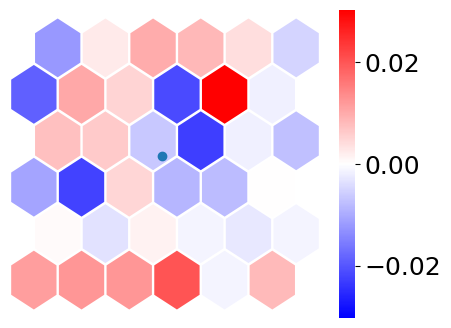

In [43]:
to_plot = get_frequency_anomaly(hs_da, labels[da_s_to_da_T])
kwargs = {
    "cmap": 'bwr',
    "norm": Normalize(- np.amax(np.abs(to_plot)), np.amax(np.abs(to_plot)))
}
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    draw_cbar=True,
    **kwargs,
)
x, y = net.neighborhoods.coordinates[bmus_da.loc[np.concatenate(heat_waves_ts)].values].mean(axis=0)
ax.scatter(x, y)
plt.show()

## <a id='toc1_2_'></a>[Events basis](#toc0_)

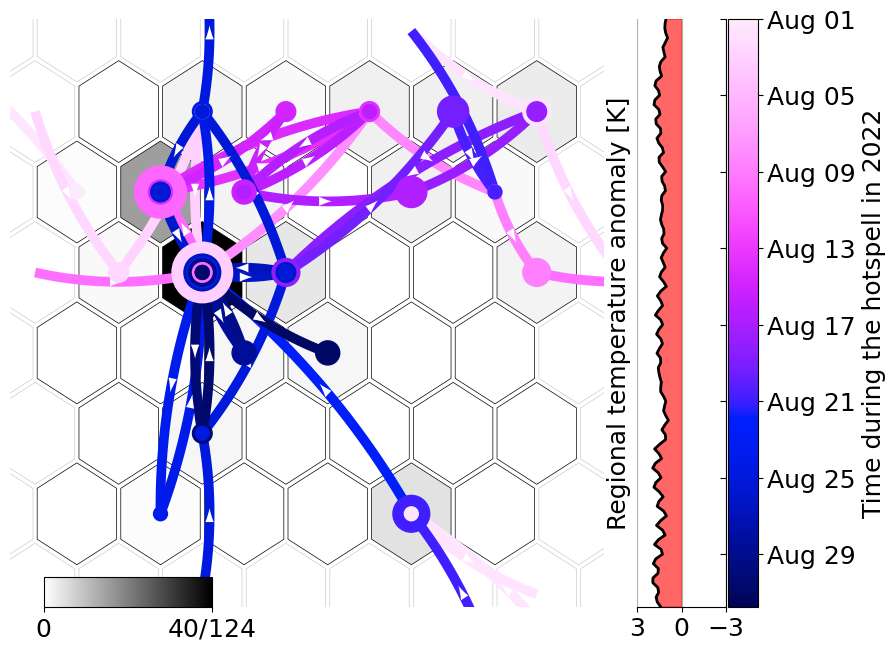

In [5]:
season = da_cee.sel(time=(da_cee.time.dt.year == 2022) & (da_cee.time.dt.month == 8)).time.values
fig, ax, cbar = plt_traj_hotspell(season, bmus_da, da_cee)
fig.savefig(f'{FIGURES}/som_props/hotspell_2022.png', dpi=300, bbox_inches='tight')

# <a id='toc2_'></a>[More or less jumps ?](#toc0_)

In [6]:
da_cee.resample(time='1Y').mean().values

array([-0.07726, -0.28257, -0.28039, -0.30064, -0.32121, -0.11819,
       -0.17566, -0.10307, -0.35808, -0.47515, -0.30962, -0.13322,
       -0.06977,  0.13141, -0.07675, -0.20095, -0.58205, -0.11424,
       -0.42638, -0.1988 , -0.04774, -0.06284, -0.69428, -0.43103,
       -0.49582, -0.5529 , -0.1985 , -0.25963, -0.64634, -0.53744,
       -0.42608, -0.44065, -0.2085 , -0.26015, -0.44736, -0.24914,
       -0.45048, -0.29568, -0.7737 , -0.38379, -0.33231, -0.0815 ,
       -0.57439, -0.3116 , -0.24902, -0.27355, -0.39185, -0.17738,
        0.26956,  0.26984,  0.1516 ,  0.06916, -0.64732, -0.26844,
       -0.11319,  0.32371, -0.2148 , -0.00393,  0.58646,  0.32105,
        0.14415,  0.38718,  0.37341,  0.7244 ,  0.39297,  0.54505,
        0.68418,  0.57326,  0.59763,  0.33328,  0.99404,  0.5312 ,
        1.06274,  0.70795,  0.70364,  0.48182,  1.16987,  0.62356,
        0.82211,  0.84845,  0.93608,  1.26219,  1.15319], dtype=float32)

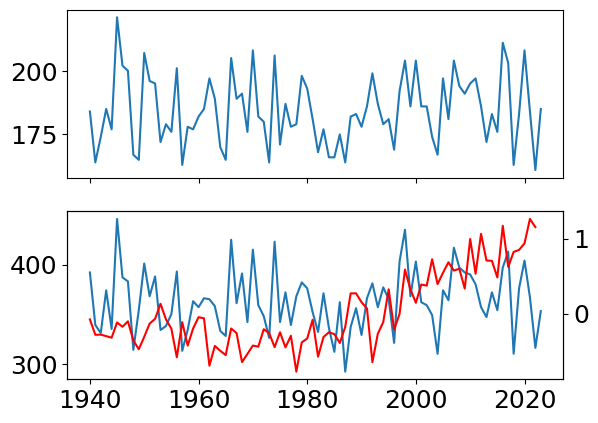

In [7]:
dist_mat = net.neighborhoods.distances
years = np.unique(bmus_da.time.dt.year.values)
jumps_per_year = []
distance_per_year = []
for year in years:
    nodes = bmus_da.sel(time=bmus_da.time.dt.year == year).values
    jumps = np.diag(dist_mat[nodes[:-1], :][:, nodes[1:]])
    jumps_per_year.append(np.sum(jumps > 0))
    distance_per_year.append(np.sum(jumps))
fig, axes = plt.subplots(2, 1, sharex='all')
axes[0].plot(years, jumps_per_year)
axes[1].plot(years, distance_per_year)
axes[1].twinx().plot(years[:-1], da_cee.resample(time='1Y').mean().values, color='red')

In [8]:
jumps = bmus_da[:-1].copy(data=dist_mat[bmus_da[:-1], bmus_da[1:]])

In [ ]:
heat_waves_jumps = {'distance': [], 'ref_distrib': [], 'significative': []}
for heat_wave in heat_waves_ts:
    len_ = len(heat_wave)
    start_month = heat_wave[0].month
    start_times = np.where(bmus_da.time.dt.month==start_month)[0]
    indices = start_times[:, None] + np.arange(len_)[None, :]
    ref_distrib = np.sum(jumps.values[indices], axis=1)
    compare_against = np.quantile(ref_distrib, q=0.01)
    heat_wave_distance = np.sum(jumps.loc[heat_wave].values)
    heat_waves_jumps['distance'].append(heat_wave_distance)
    heat_waves_jumps['ref_distrib'].append(np.sort(ref_distrib))
    heat_waves_jumps['significative'].append(heat_wave_distance <= compare_against)
np.where(heat_waves_jumps['significative'])[0]

array([31])

In [ ]:
yearbreaks = np.sum(bmus_da.time.dt.year == bmus_da.time.dt.year[0]).item()
possible_tuples = [
    (i, j) for i, j in product(range(net.n_nodes), range(net.n_nodes))
]
possible_tuples = np.asarray(possible_tuples, dtype='i,i')
indices = [i for n in range(len(np.unique(bmus_da.time.dt.year))) for i in range(n * yearbreaks, (n + 1) * yearbreaks - 1)]
transitions = np.zeros(len(da_s.time), dtype='i, i')
transitions[indices] = [(net.bmus[i], net.bmus[i + 1]) for i in indices]
transition_masks = transitions[:, None] == possible_tuples[None, :]
unique_transitions, counts = np.unique(transitions, return_counts=True)
trans_mat = np.zeros((net.n_nodes, net.n_nodes))
trans_mat[unique_transitions['f0'], unique_transitions['f1']] = counts
sort_order = np.argsort(counts)[::-1][:50]
sort_order_1 = [i for i in sort_order if unique_transitions[i][0] == unique_transitions[i][1]]
sort_order_2 = [i for i in sort_order if unique_transitions[i][0] != unique_transitions[i][1]]

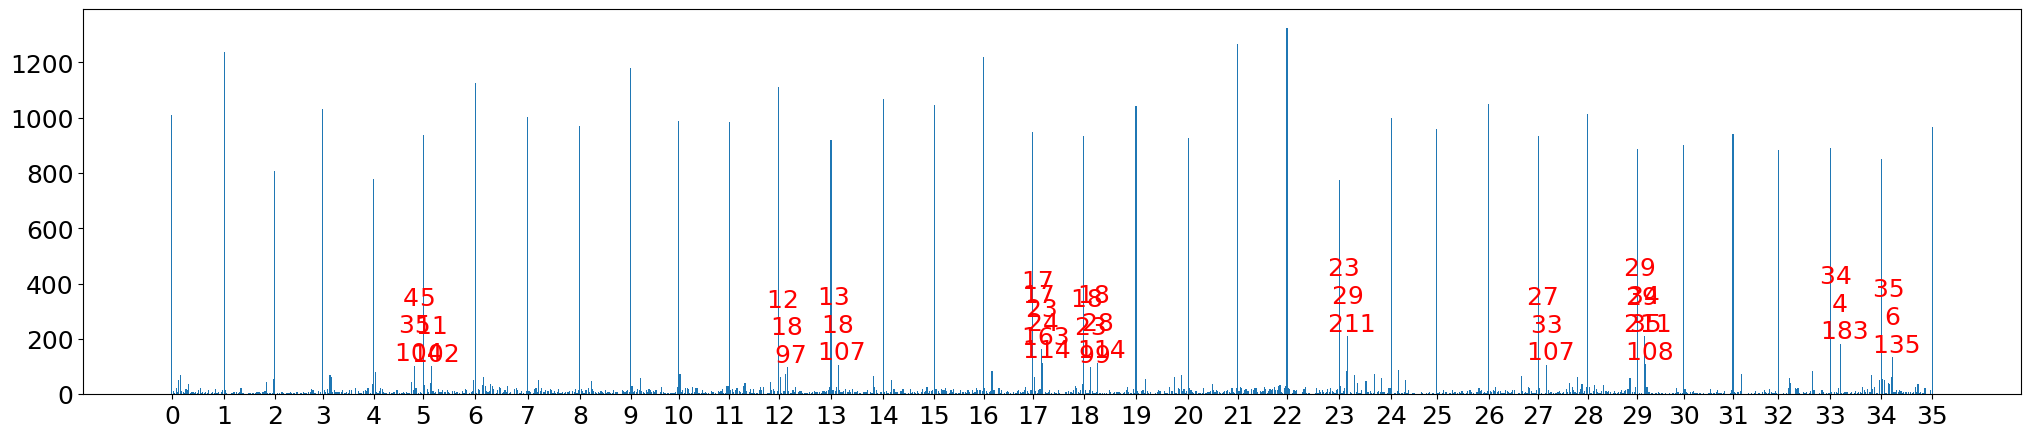

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(np.arange(len(counts)), counts)
ax.set_xticks(sort_order_1, unique_transitions['f0'][sort_order_1])
for i in sort_order_2:
    xy = (i, counts[i])
    xytext = (i, counts[i])
    plt.annotate(f'{unique_transitions[i][0]} \n {unique_transitions[i][1]} \n {counts[i]}', xy=xy, xytext=xytext, ha='center', va='bottom', color='red')

In [ ]:
unique_transitions_heat_waves, counts_heat_waves = np.unique(transitions[np.where(np.isin(bmus_da.time.values, np.concatenate(heat_waves_ts)))[0]], return_counts=True)

In [ ]:
all_to_hs = np.isin(unique_transitions, unique_transitions_heat_waves)
counts_heat_waves - counts[all_to_hs]
# counts_heat_waves

array([ -984,   -51,   -67,   -14,   -37,    -6,   -19,    -6,    -3,
        -988,   -67,   -60,   -15,    -8,    -5,   -15,   -12,   -15,
         -22,  -775,    -9,   -11,    -5,  -929,   -31,  -101,   -12,
         -17,   -13,   -10,   -50, -1071,   -30,   -59,   -28,   -10,
          -7,   -11,   -29,   -17,   -13,    -6,   -18,   -22,   -13,
         -12,  -987,    -8,    -4,   -11,   -19,   -19,  -963,   -10,
         -16, -1129,   -28,   -57,   -11,   -12,   -12,  -957,   -16,
         -26,    -9,   -21,   -22,    -9,   -16,   -27,  -963,   -19,
         -14,   -22,   -27,    -3,   -17,    -5,   -16,   -25,   -42,
         -12, -1071,   -59,    -5,   -10,   -73,   -91,   -25,    -6,
          -5,   -15,   -24,  -905,  -102,   -16,    -9,    -7,    -6,
         -63,    -7, -1046,    -4,   -49,    -6,   -10,   -12,   -13,
       -1030,   -16,   -15,   -17,    -8,    -6,    -5,   -20,   -14,
       -1175,   -19,   -12,   -13,    -3,    -7,    -9,   -23,    -3,
         -11,  -910,

In [13]:
bmus_da.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/bmus_da.nc')
np.save('/storage/homefs/hb22g102/persistent-extremes-era5/results/heat_waves_cee.npy', heat_waves)

## <a id='toc2_1_'></a>[Whole period, attribution and conditional probas](#toc0_)

In [ ]:
num_lags = 3 * 4
hotspells = get_hotspells_v2(lag_behind=num_lags)[0]
clustered_hotspells = {region: [[] for _ in range(net.n_nodes)] for region in REGIONS}
unattributed = {region: [] for region in REGIONS}
for k, region in enumerate(REGIONS):
    for j, hotspell in enumerate(hotspells[k]):
        try:
            unique, counts = np.unique(labels.loc[hotspell[:2 * num_lags]], return_counts=True)
            remove_zero = unique != 0
            unique = unique[remove_zero] - 1
            counts = counts[remove_zero]
            where = np.argmax(counts)
            clustered_hotspells[region][int(unique[where])].append((len(hotspell), j))
        except KeyError:
            unattributed[region].append((len(hotspell), j))
            

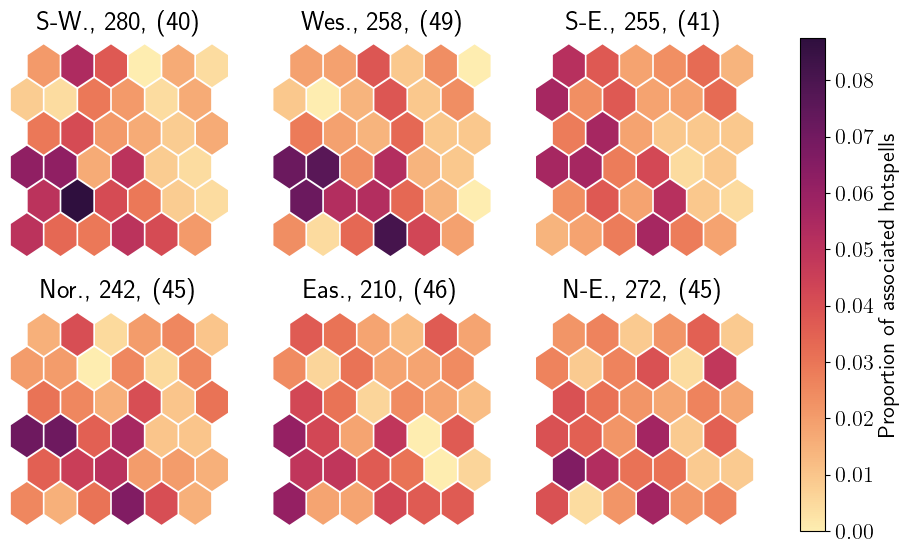

In [ ]:

to_plot = np.asarray([[len(cluhs) for cluhs in list_of_nodes] for list_of_nodes in clustered_hotspells.values()])
denominator = np.asarray([len(hs) for hs in hotspells]) - np.asarray([len(unat) for unat in unattributed.values()])
to_plot = to_plot / denominator[:, None]
kwargs = {
    "cmap": colormaps.matter,
    "norm": Normalize(0, np.amax(to_plot))
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
axes = axes.ravel()
for k, (region, tplt) in enumerate(zip(REGIONS, to_plot)):
    ax = axes[k]
    fig, ax = net.plot_on_map(
        tplt,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        **kwargs,
    )
    ax.set_title(f"{region[:3]}., {len(hotspells[k])}, ({len(unattributed[region])})")
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label="Proportion of associated hotspells")
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')


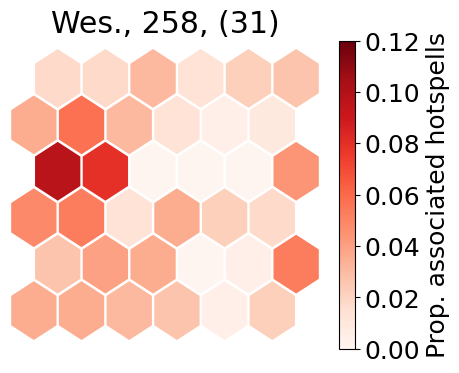

In [ ]:
kwargs = {
    "cmap": "Reds",
    "norm": Normalize(0, 0.12),
}
fig, ax = plt.subplots(figsize=(5, 4))
region = "West"
k = 1
list_of_nodes = clustered_hotspells[region]
tplt = np.asarray([len(l) for l in list_of_nodes])
fig, ax = net.plot_on_map(
    tplt / (len(hotspells[k]) - len(unattributed[region])),
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=False,
    **kwargs,
)
ax.set_title(f"{region[:3]}., {len(hotspells[k])}, ({len(unattributed[region])})")
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label="Prop. associated hotspells")
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')


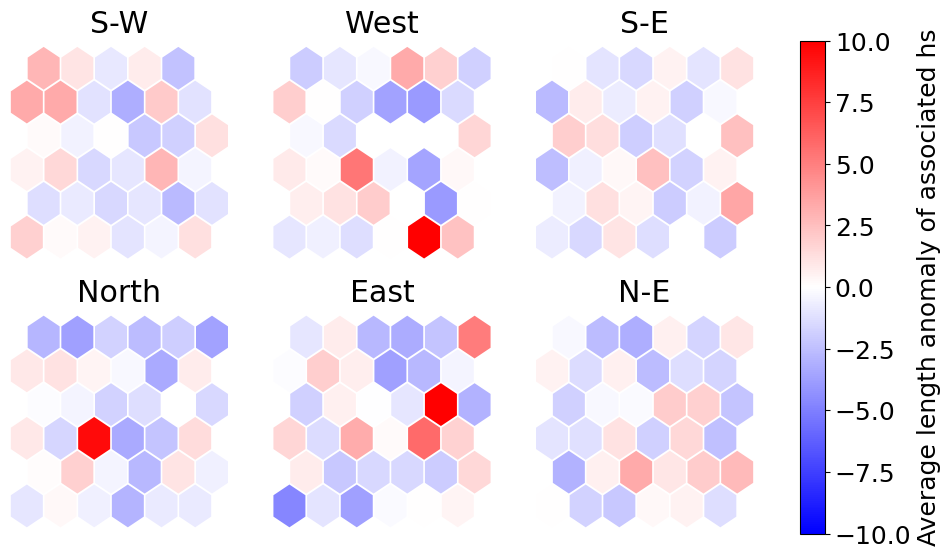

In [ ]:
kwargs = {
    "cmap": "bwr",
    "norm": Normalize(-10, 10),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
axes = axes.ravel()
for k, (region, list_of_nodes) in enumerate(clustered_hotspells.items()):
    ax = axes[k]
    tplt = [np.mean([hs_info[0] for hs_info in l]) for l in list_of_nodes]
    fig, ax = net.plot_on_map(
        tplt - np.nanmean([len(l) for l in hotspells[k]]),
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        **kwargs
    )
    ax.set_title(region)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label="Average length anomaly of associated hs")
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')
